In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib inline

# Чтение и парсинг csv файла

In [134]:
def get_img(img_num, pair_num):
    data = pd.read_csv('test.csv')                             # картинки представляют из себя строки
    data2 = data[f'img_{pair_num}'][img_num][1:-1].split(", ") # выбираем картинку и переводим ее в массив
    data3 = np.array([int(d) for d in data2])
    shape = data[f'img_shape_{pair_num}'][img_num][1:-1].split(", ") # парсим форму картинки
    shape = np.array([int(d) for d in shape])
    data4 = data3.reshape(shape)
    return data4.astype(np.uint8)

In [135]:
def _plot(num):
    plt.figure(figsize=(15,8))
    plt.subplot(1, 2, 1)
    plt.imshow(get_img(num,1))
    plt.title("source_1")
    plt.subplot(1, 2, 2)
    plt.imshow(get_img(num,2))
    plt.title("source_2");

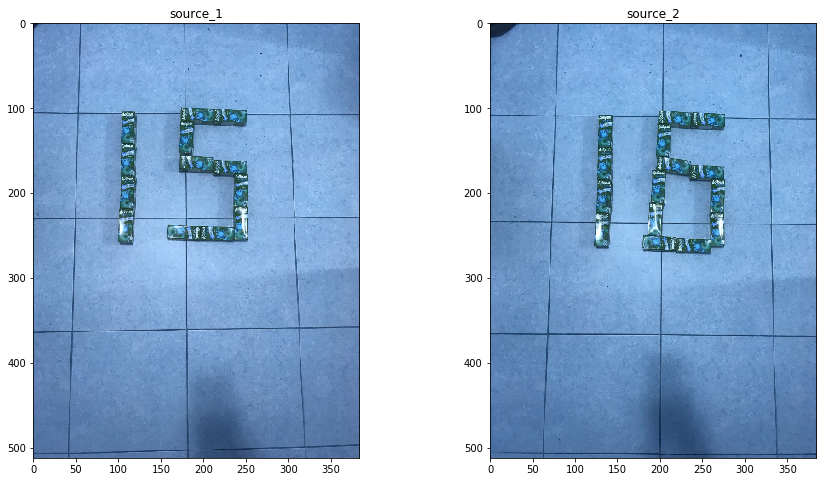

In [136]:
_plot(1)

## Первый вариант

In [137]:
def detector_windowed(in_fname_1, in_fname_2, out_fname=None):
    # Считываем входящие данные
    arr1 = np.array(in_fname_1)[:,:,::-1]
    arr2 = np.array(in_fname_2)[:,:,::-1]
    shape = in_fname_2.shape

    # Создаем переменные детектирования
    detections = np.zeros((shape[0], shape[1]), dtype='uint8')

    # Задаем параметры бегущего окна
    step = 20
    win = 40
    for i in range(0, shape[0]-win, step):
        for j in range(0, shape[1]-win, step):
            chip1 = arr1[i:i+win,j:j+win,::]
            chip2 = arr2[i:i+win,j:j+win,::]
            hist_1 = cv.calcHist([cv.cvtColor(chip1.copy(), cv.COLOR_BGR2GRAY)], [0], None, [256], [0,256])
            hist_2 = cv.calcHist([cv.cvtColor(chip2.copy(), cv.COLOR_BGR2GRAY)], [0], None, [256], [0,256])
            cor_ge = cv.compareHist(hist_1, hist_2, cv.HISTCMP_CORREL)
            #print(cor_ge)
            res = compare( phash(chip1), phash(chip2))
            if cor_ge <= 0.7 and res == 1:
                detections[i:i+win,j:j+win] = 100
                #print(detections[i:i+win,j:j+win])
           
    return detections

In [138]:
def compare(hesh1, hesh2):
    dif_num = 0
    for index in range(len(hesh1)):
        if hesh1[index] != hesh2[index]:
            dif_num +=1
    if dif_num > 7:
        return 1
    else:
        return 0

In [139]:
def phash(chip):
    chip = cv.cvtColor(chip, cv.COLOR_BGR2GRAY)
    chip = cv.resize(chip,(32, 32))
    imf = np.float32(chip)/255.0
    chip = cv.dct(imf)
    chip = chip[0:8,0:8]
    average_color = 0
    for i in range(0, 8):
        for j in range(0, 8): 
            average_color += chip[i][j]
    average_color /= 63
    hesh = ''
    for i in range(0, 8):
        for j in range(0, 8): 
            if chip[i][j] >= average_color:
                hesh += '1'
            else:
                hesh += '0'
    hesh = hex(int(hesh, 2))
    mod = ''
    for i in range(0, 18 - len(hesh)):
        mod += '0'
    hesh = mod + hesh
    
    return hesh

In [140]:
def erosion_correction(dif, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    opening = cv.morphologyEx(dif, cv.MORPH_OPEN, kernel)
    opening = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
    return opening

In [141]:
dif = detector_windowed(get_img(5,1), get_img(5,2))
print(dif.shape)
dif = erosion_correction(dif)
print(dif.shape)

(512, 384)
(512, 384)


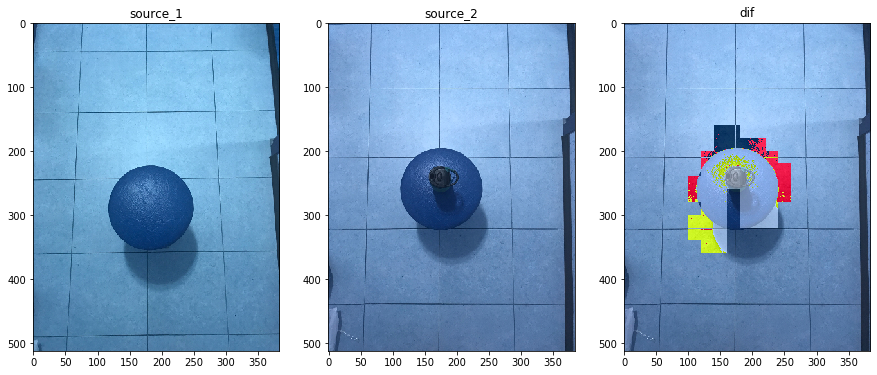

In [142]:
plt.figure(figsize=(15,8))
plt.subplot(1, 3, 1)
plt.imshow(get_img(5,1))
plt.title("source_1")
plt.subplot(1, 3, 2)
plt.imshow(get_img(5,2))
plt.title("source_2");
plt.subplot(1, 3, 3)
res = get_img(5,2)
res[:,:,0] += dif
res[:,:,1] += dif
res[:,:,2] += dif
plt.imshow(res)
plt.title("dif");

## С преобразованием

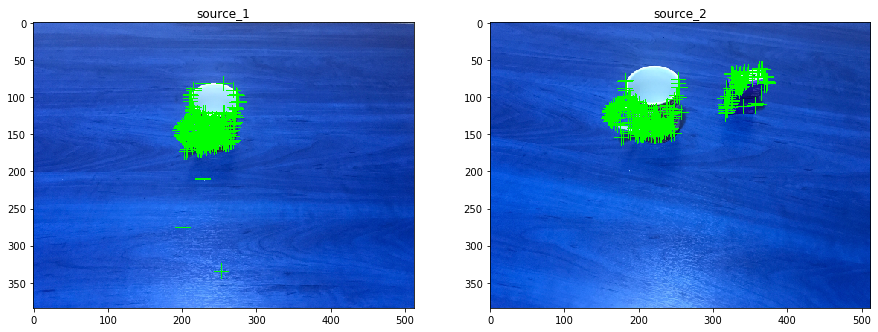

In [143]:
orb = cv.ORB_create()  
plt.figure(figsize=(15,8))
plt.title('ORB Interest Points 1')
plt.subplot(1, 2, 1)
img1 = get_img(8,1)
key_points_1, description_1 = orb.detectAndCompute(img1, None)
for marker in key_points_1:
    img1_kp = cv.drawMarker(img1, tuple(int(i) for i in marker.pt), color=(0, 255, 0))
plt.imshow(img1_kp)
plt.title("source_1")
plt.subplot(1, 2, 2)
img2 = get_img(8,2)
key_points_2, description_2 = orb.detectAndCompute(img2, None)
for marker in key_points_2:
    img2_kp = cv.drawMarker(img2, tuple(int(i) for i in marker.pt), color=(0, 255, 0))
plt.imshow(img2_kp)
plt.title("source_2");

In [144]:
hessian_threshold = 5000
detector = cv.xfeatures2d.SIFT_create()
hkeypoints,hdescriptors = detector.detectAndCompute(img1,None)
nkeypoints,ndescriptors = detector.detectAndCompute(img2,None)

In [145]:
# extract vectors of size 64 from raw descriptors numpy arrays
rowsize = len(hdescriptors) / len(hkeypoints)
if rowsize > 1:
    hrows = np.array(hdescriptors, dtype = np.float32).reshape((-1, rowsize))
    nrows = np.array(ndescriptors, dtype = np.float32).reshape((-1, rowsize))
    #print hrows.shape, nrows.shape
else:
    hrows = np.array(hdescriptors, dtype = np.float32)
    nrows = np.array(ndescriptors, dtype = np.float32)
    rowsize = len(hrows[0])

In [146]:
# kNN training - learn mapping from hrow to hkeypoints index
samples = hrows
responses = np.arange(len(hkeypoints), dtype = np.float32)
#print len(samples), len(responses)
knn = cv.ml.KNearest_create()
knn.train(samples,cv.ml.ROW_SAMPLE, responses)

True

In [147]:
# retrieve index and value through enumeration
def sort_des(nrows, hkeypoints, img1, img2):
    for i, descriptor in enumerate(nrows):
        descriptor = np.array(descriptor, dtype = np.float32).reshape((1, rowsize))
        #print i, descriptor.shape, samples[0].shape
        retval, results, neigh_resp, dists = knn.findNearest(descriptor, 1)
        res, dist =  int(results[0][0]), dists[0][0]
        #print res, dist

        if dist < 0.1:
            # draw matched keypoints in red color
            color = (0, 0, 255)
        else:
            # draw unmatched in blue color
            color = (255, 0, 0)
        # draw matched key points on haystack image
        x,y = hkeypoints[res].pt
        center = (int(x),int(y))
        cv.circle(img1,center,5,color,-1)
        # draw matched key points on needle image
        x,y = nkeypoints[i].pt
        center = (int(x),int(y))
        cv.circle(img2,center,5,color,-1)
        
sort_des(nrows, hkeypoints, img1, img2)

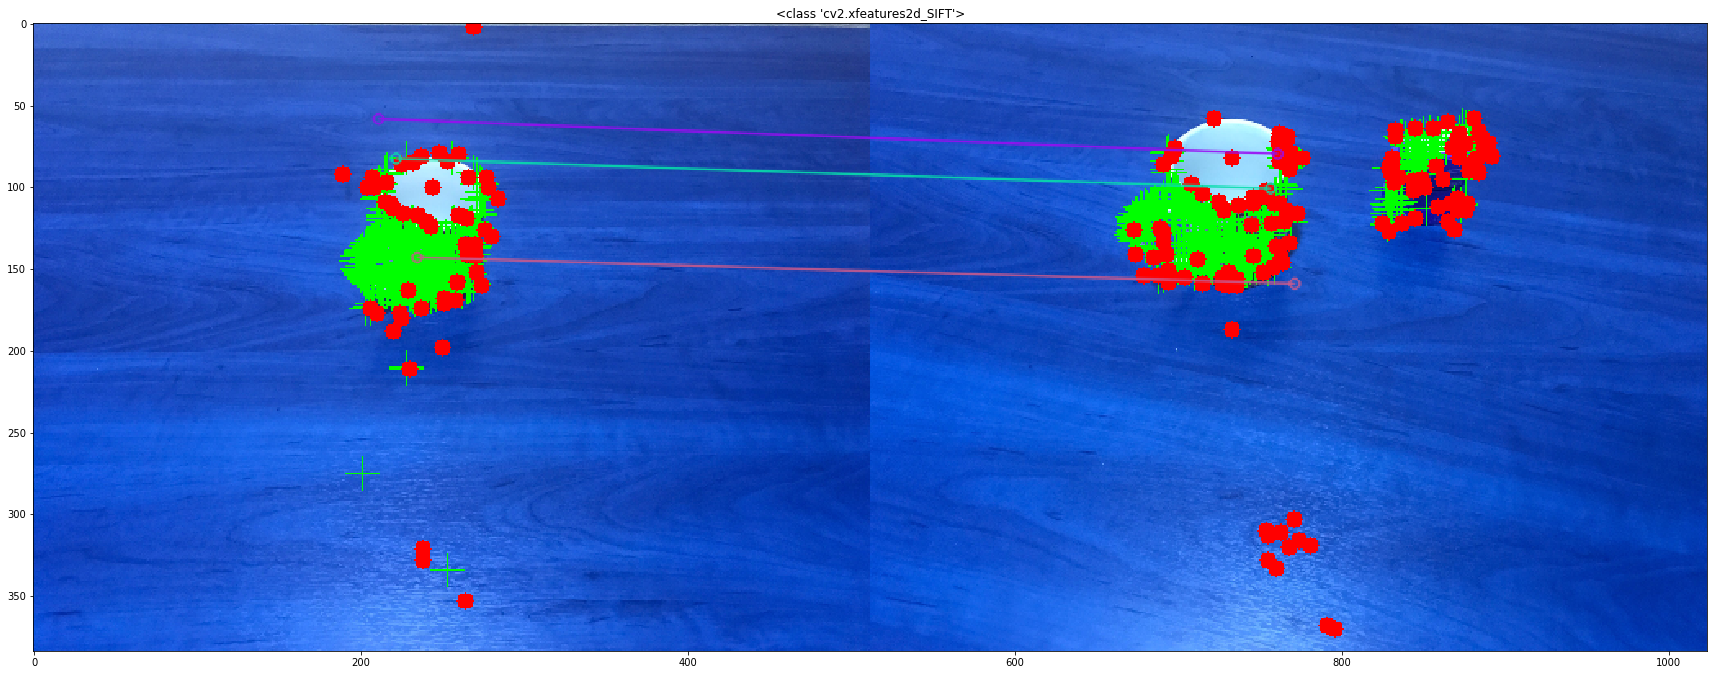

In [148]:
def find_matches(hdescriptors, img1, img2, nkeypoints, hkeypoints):
    bf = cv.BFMatcher(cv.NORM_L1,crossCheck=True) # crossCheck not supported by BFMatcher
    clusters = np.array([hdescriptors])
    bf.add(clusters)

    # Train: Does nothing for BruteForceMatcher though.
    bf.train()

    matches = bf.match(ndescriptors)
    matches = sorted(matches, key = lambda x:x.distance)
    nmatches = 10

    img_matches = cv.drawMatches(img1, nkeypoints, img2, hkeypoints, matches[:3], img2, flags=2) 
    # Show top 10 matches
    plt.figure(figsize=(30, 30))
    plt.title(type(detector))
    plt.imshow(img_matches)
    plt.show()
    
find_matches(hdescriptors, img1, img2, nkeypoints, hkeypoints)

In [149]:
def get_coordinate(nmatches, img1_idx, img2_idx):
    coord_list1 = []
    coord_list2 = []

    for index in range(0 , nmatches):
        mat = matches[index]
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1,y1) = nkeypoints[img1_idx].pt
        (x2,y2) = nkeypoints[img2_idx].pt
        coord_list1.append([x1,y1])
        coord_list2.append([x2,y2])
    return coord_list1, coord_list2

get_coordinate(nmatches, img1_idx, img2_idx)

([[234.50927734375, 142.84765625],
  [210.91415405273438, 58.130836486816406],
  [221.5388641357422, 82.46846771240234],
  [250.00465393066406, 67.66956329345703],
  [200.943603515625, 144.837890625],
  [234.85421752929688, 106.43464660644531],
  [255.85305786132812, 69.87490844726562],
  [221.56741333007812, 187.3997344970703],
  [257.53228759765625, 85.17341613769531],
  [257.39715576171875, 79.66322326660156]],
 [[243.45472717285156, 328.9288330078125],
  [234.5966796875, 110.05714416503906],
  [234.50927734375, 142.84765625],
  [233.12612915039062, 123.7335433959961],
  [213.4101104736328, 109.2188949584961],
  [216.51107788085938, 114.93434143066406],
  [243.99789428710938, 313.7770080566406],
  [234.85421752929688, 106.43464660644531],
  [179.43263244628906, 133.6259002685547],
  [254.39010620117188, 73.64680480957031]])

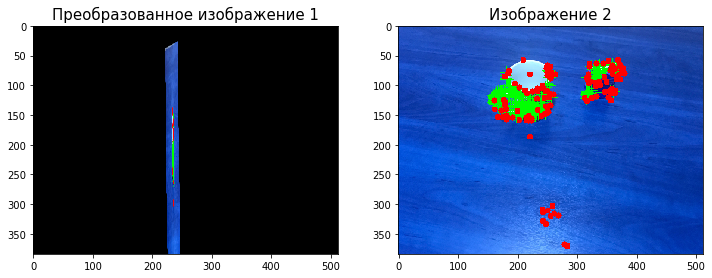

In [150]:
def get_affin(img1, coord_list1, coord_list2):
    M = cv.getAffineTransform(np.float32(coord_list1[1:4]), np.float32(coord_list2[1:4])) 
    dst = cv.warpAffine(img1.copy(), M, (img1.shape[1],img1.shape[0]))

    fig, m_axs = plt.subplots(1, 2, figsize=(12,8))
    ax1, ax2 = m_axs

    ax1.set_title('Преобразованное изображение 1', fontsize=15)
    ax1.imshow(dst)
    ax2.set_title('Изображение 2', fontsize=15)
    ax2.imshow(img2);
get_affin(img1, coord_list1, coord_list2)

In [151]:
def find_borders(img):
    gray = cv.GaussianBlur(img, (3, 3), 0)
    slice1Copy = np.uint8(gray)
    edged = cv.Canny(slice1Copy, 7, 350, 350)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (7, 7))
    closed = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel)
    th3 = cv.adaptiveThreshold(closed, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 3)
    return th3

In [152]:
def fourier(_img):
    #img = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
    img = _img
    r = 10

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    M = np.max(magnitude_spectrum)
    coord = np.where(magnitude_spectrum == M)
    for x in range(0, len(fshift[0])):
        for y in range(0, len(fshift[1])):
            if ((x - coord[0])**2 + (y - coord[1])**2 ) < r**2:
                fshift[x][y] = 1
    peps = np.fft.ifftshift(fshift)
    peps = np.fft.ifft2(peps)
    peps = np.real(peps)
    return peps

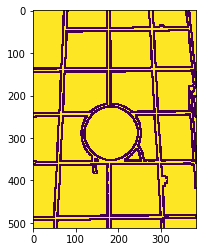

In [153]:
img1 = find_borders(get_img(5,1))
img2 = find_borders(get_img(5,2))
plt.imshow(img1);

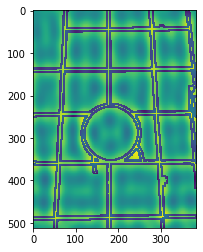

In [154]:
plt.imshow(fourier(img1));
img1 = fourier(img1)
img2 = fourier(img2)

## Подготовим ответ для kaggle

In [243]:
def rle_encode(img):
    '''
    Кодировка ответа для kaggle, на вход сюда подавать маску
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [246]:
mask_arr_sub = []    # маски отличий
for i in range(12):
    ans = detector_windowed(get_img(i,1), get_img(i,2))
    mask_arr_sub.append(rle_encode(ans))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11


In [247]:
mask_arr_sub

['30361 40 30614 40 30867 40 31120 40 31373 40 31626 40 31879 40 32132 40 32385 40 32638 40 32891 40 33144 40 33397 40 33650 40 33903 40 34156 40 34409 40 34662 40 34915 40 35168 40 35421 40 35674 40 35927 40 36180 40 36433 40 36686 40 36939 40 37192 40 37445 40 37698 40 37951 40 38204 40 38457 40 38710 40 38963 40 39216 40 39469 40 39722 40 39975 40 40228 40',
 '41201 40 41713 40 42225 40 42737 40 43249 40 43761 40 44273 40 44785 40 45297 40 45809 40 46321 40 46833 40 47345 40 47857 40 48369 40 48881 40 49393 40 49905 40 50417 40 50929 40 51401 80 51913 80 52425 80 52937 80 53449 80 53961 80 54473 80 54985 80 55497 80 56009 80 56521 80 57033 80 57545 80 58057 80 58569 80 59081 80 59593 80 60105 80 60617 80 61129 80 61641 80 62153 80 62665 80 63177 80 63689 80 64201 80 64713 80 65225 80 65737 80 66249 80 66761 80 67273 80 67785 80 68297 80 68809 80 69321 80 69833 80 70345 80 70857 80 71369 80 82021 40 82161 40 82533 40 82673 40 83045 40 83185 40 83557 40 83697 40 84069 40 84209 40 8458

In [248]:
d = {"id":[i for i in range(12)],         # формируется словарь с индексами и масками
    'mask_arr': mask_arr_sub}

In [249]:
df = pd.DataFrame(data=d)        # Словарь в DataFrame

In [250]:
df.to_csv("sample_solution.csv",index=False)